In [2]:
import sys
import matplotlib.pyplot as plt
import cv2
sys.path.append('../')

from scripts.point_cloud_utils import send_point_cloud
from pyngp.common import *
from tqdm import tqdm
import pyngp.pyngp as ngp
from  scripts.ros_utils import get_image_tf_pair

width = 854
height = 480
spp = 1 # 1 is fast 8 is default

objects = ['table', 'truck', 'block']
testbed_map = {}
for obj in objects:
    testbed = ngp.Testbed()
    testbed.load_snapshot(f'../nerf/{obj}.ingp')
    testbed_map[obj] = testbed
def srgb_to_linear(img):
    limit = 0.04045
    return np.where(img > limit, np.power((img + 0.055) / 1.055, 2.4), img / 12.92)

def linear_to_srgb(img):
    limit = 0.0031308
    return np.where(img > limit, 1.055 * (img ** (1.0 / 2.4)) - 0.055, 12.92 * img)

camera_matrix = testbed_map['table'].camera_matrix



21:09:10 SUCCESS  Initialized CUDA 12.0. Active GPU is #0: NVIDIA GeForce RTX 4090 [89]
21:09:10 INFO     Loading network snapshot from: ../nerf/table.ingp
21:09:14 DEBUG    GPUMemory: allocating 1.41 KB.
21:09:14 DEBUG    GPUMemory: allocating 144 B.
21:09:14 DEBUG    GPUMemory: allocating 144 B.
21:09:14 DEBUG    GPUMemory: allocating 144 B.
21:09:14 DEBUG    GPUMemory: allocating 144 B.
21:09:14 DEBUG    GPUMemory: allocating 8 B.
21:09:14 DEBUG    GPUMemory: allocating 1.12 KB.
21:09:14 DEBUG    GPUMemory: allocating 4 MB.
21:09:14 DEBUG    GPUMemory: allocating 8 MB.
21:09:14 DEBUG    GPUMemory: allocating 2 MB.
21:09:14 DEBUG    GPUMemory: allocating 64 KB.
21:09:14 INFO     GridEncoding:  Nmin=16 b=2 F=4 T=2^22 L=8
21:09:14 DEBUG    GridEncoding at level 0: resolution=16 params_in_level=4096
21:09:14 DEBUG    GridEncoding at level 1: resolution=32 params_in_level=32768
21:09:14 DEBUG    GridEncoding at level 2: resolution=64 params_in_level=262144
21:09:14 DEBUG    GridEncoding 

In [115]:
ros_image, tf = get_image_tf_pair(image_topics=['camera_image'], tf_names=['camera_frame'])
tf = tf[0]
ros_image = ros_image[0]

c2w = tf
c2w[0:3, 2] *= -1  # flip the y and z axis
c2w[0:3, 1] *= -1
c2w = c2w[[1, 0, 2, 3], :]
c2w[2, :] *= -1  # flip whole world upside down
tf = c2w
tf = tf[:-1, :]

testbed.set_nerf_camera_matrix(tf)
camera_matrix2 = testbed.camera_matrix

depth_buffer = 10000000*np.ones((height, width))
image_composed = np.zeros((height, width, 3))



for obj in objects:
    testbed = testbed_map[obj]
    testbed.camera_matrix = camera_matrix2
    testbed.nerf.render_min_transmittance = 0.01
    testbed.render_mode = ngp.RenderMode.Shade
    testbed.color_space = ngp.ColorSpace.Linear
    image = testbed.render(width, height, spp, True)
    testbed.nerf.render_min_transmittance = 0.9
    testbed.render_mode = ngp.RenderMode.Depth
    depth = testbed.render(width, height, spp, True)
    depth = depth[:,:,0]
    inds = (depth < depth_buffer) * (depth > 0.05)
    image_composed[inds, 0] = image[inds, 0]
    image_composed[inds, 1] = image[inds, 1]
    image_composed[inds, 2] = image[inds, 2]
    depth_buffer[inds] = depth[inds]

image_composed = linear_to_srgb(image_composed)


[WARN] [1694655395.503932979] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


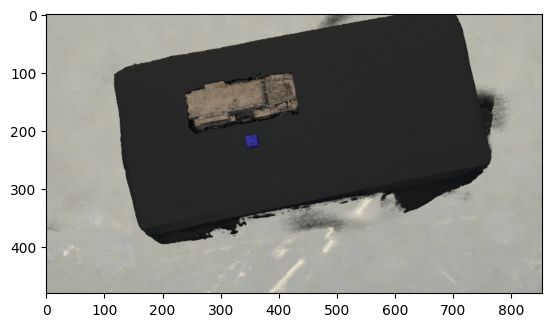

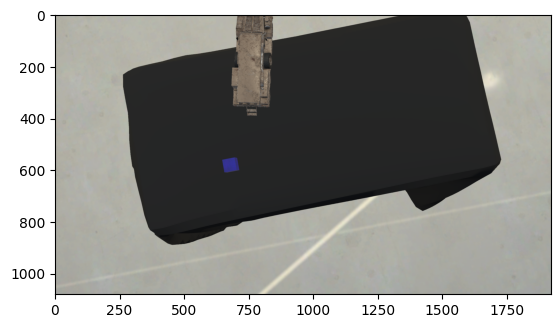

In [116]:
plt.figure()
plt.imshow(image_composed)
plt.figure()
plt.imshow(ros_image)


In [117]:
sys.path.append('../unimatch_repo')

import torch
import torch.nn.functional as F
from unimatch.unimatch import UniMatch
from evaluate_flow import inference_flow
from utils.flow_viz import flow_to_image
from PIL import Image as im

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UniMatch(feature_channels=128,
                 num_scales=2,
                 upsample_factor=4,
                 num_head=1,
                 ffn_dim_expansion=4,
                 num_transformer_layers=6,
                 reg_refine=True,
                 task='flow').to(device)

trained_model_path = '../unimatch_repo/pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth'
inference_dir = '../unimatch_repo/demo/nerf'
output_dir = '../unimatch_repo/output'



print(image_composed.shape)
data = im.fromarray((255*image_composed[:,:,:3]).astype(np.uint8))
data.save(f'{inference_dir}/image_composed.png')
data = im.fromarray(ros_image[:,:,:3])
data.save(f'{inference_dir}/ros_image.png')

loc = 'cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(trained_model_path, map_location=loc)
model.load_state_dict(checkpoint['model'], strict=False)
# model.eval()

(480, 854, 3)


<All keys matched successfully>

0.1161043643951416


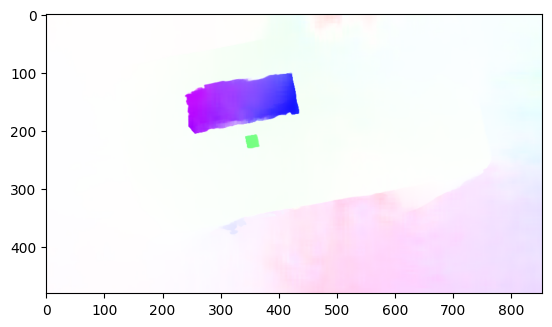

In [118]:
# from utils import frame_utils
# image1 = frame_utils.read_gen(filenames[test_id])
# image2 = frame_utils.read_gen(filenames[test_id + 1])
image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
image2 = ros_image[:,:,:3]
image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)

padding_factor=32
fixed_inference_size = None
# fixed_inference_size = (448, 768)

# the model is trained with size: width > height
transpose_img = False
if image1.size(-2) > image1.size(-1):
    image1 = torch.transpose(image1, -2, -1)
    image2 = torch.transpose(image2, -2, -1)
    transpose_img = True

nearest_size = [int(np.ceil(image1.size(-2) / padding_factor)) * padding_factor,
                int(np.ceil(image1.size(-1) / padding_factor)) * padding_factor]

# resize to nearest size or specified size
inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

assert isinstance(inference_size, list) or isinstance(inference_size, tuple)
ori_size = image1.shape[-2:]

# resize before inference
if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
    image1 = F.interpolate(image1, size=inference_size, mode='bilinear',
                           align_corners=True)
    image2 = F.interpolate(image2, size=inference_size, mode='bilinear',
                           align_corners=True)

    
for i in range(1):
    import time
    start = time.time()
    with torch.inference_mode():
        results_dict = model(image1, image2,
                            attn_type='swin',
                            attn_splits_list=[2, 8],
                            corr_radius_list=[-1, 4],
                            prop_radius_list=[-1, 1],
                            num_reg_refine=6,
                            task='flow'
                            )
    print(time.time() - start)

    
flow_pr = results_dict['flow_preds'][-1]

# resize back
if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
    flow_pr = F.interpolate(flow_pr, size=ori_size, mode='bilinear',
                            align_corners=True)
    flow_pr[:, 0] = flow_pr[:, 0] * ori_size[-1] / inference_size[-1]
    flow_pr[:, 1] = flow_pr[:, 1] * ori_size[-2] / inference_size[-2]

if transpose_img:
    flow_pr = torch.transpose(flow_pr, -2, -1)

flow = flow_pr[0].permute(1, 2, 0).cpu().numpy()  # [H, W, 2]

plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

In [119]:
# with torch.inference_mode():
#     inference_flow(model,
#                     inference_dir=inference_dir,
#                     output_path=output_dir,
#                     padding_factor=32,
#                     attn_type='swin',
#                     attn_splits_list=[2, 8],
#                     corr_radius_list=[-1, 4],
#                     prop_radius_list=[-1, 1],
#                     num_reg_refine=6,
#                     )